# Context
"COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a popular commercial algorithm used by judges and parole officers for scoring criminal defendant’s likelihood of reoffending (recidivism). It has been shown that the algorithm is biased in favor of white defendants, and against black inmates, based on a 2 year follow up study (i.e who actually committed crimes or violent crimes after 2 years). The pattern of mistakes, as measured by precision/sensitivity is notable."

### What are we going to perform on this notebook?
* For this we will make use of a dataset available at https://github.com/propublica/compas-analysis.
* We will load the data and perform an exploratory analysis and data quality assessment required for the remainder of the case. Specifically, assess the completeness, validity and timeliness of the data and propose mitigation strategies for potential problems encountered.
* Are the "is_recid" and "is_violent_recid" fields in this dataset adequate to assess the accuracy of the risk estimates generated by the COMPAS system? 
* The threshold for establishing measures to prevent recidivism is 7 and above. We will generate a contingency table, explaining which case is considered as "positive" (and, therefore, which are type I errors and type II errors).
* The system assigns, on average, higher risk assessments to men than to women, and to African Americans than to Caucasians. However, recidivism rates are also higher for these groups. We will show these differences through graphical representations and use them to analyze whether or not the assignment of assessments is fair.





In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("white")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import os
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  


Before I start, I have already seen that there are many date columns that appear in object format,so I use parse dates in pd.read_csv to convert them to time format.

In [2]:
path = "../input/compas-other-version/compas.csv"

date_cols = ["compas_screening_date","dob","c_jail_in","c_jail_out","c_offense_date","v_screening_date","screening_date",
"vr_offense_date","r_jail_out","r_jail_in","r_offense_date","c_arrest_date"]

df = pd.read_csv(path,parse_dates=date_cols)
df.head(3)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaT,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,NaT,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27


In [3]:
# we see an overview where we see the type of data in each column, if there is Nan, the memory usage, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       11757 non-null  int64         
 1   name                     11757 non-null  object        
 2   first                    11757 non-null  object        
 3   last                     11757 non-null  object        
 4   compas_screening_date    11757 non-null  datetime64[ns]
 5   sex                      11757 non-null  object        
 6   dob                      11757 non-null  datetime64[ns]
 7   age                      11757 non-null  int64         
 8   age_cat                  11757 non-null  object        
 9   race                     11757 non-null  object        
 10  juv_fel_count            11757 non-null  int64         
 11  decile_score             11757 non-null  int64         
 12  juv_misd_count           11757 n

In [4]:
# we see that there are a lot of null values, so we will have to make some adjustments later on.
# remember that the prefix r_ stands for recidivist, and vr_ violent recidivist.
nulos = df.isnull().mean()
nulos[nulos >0] 

days_b_screening_arrest    0.100366
c_jail_in                  0.100366
c_jail_out                 0.100366
c_case_number              0.063111
c_offense_date             0.221145
c_arrest_date              0.841966
c_days_from_compas         0.063111
c_charge_desc              0.063707
num_r_cases                1.000000
r_case_number              0.685039
r_days_from_arrest         0.790763
r_offense_date             0.685039
r_charge_desc              0.690142
r_jail_in                  0.790763
r_jail_out                 0.790763
num_vr_cases               1.000000
vr_case_number             0.924981
vr_charge_degree           0.924981
vr_offense_date            0.924981
vr_charge_desc             0.924981
v_score_text               0.000425
score_text                 0.001276
dtype: float64

In principle there are no duplicates, but just in case, let's check the names, age, sex, date of birth and breed. So we see that there are two duplicate names but with different screening_Date dates. 
Looking closely at each one I notice that the duplicates
are marked with is_recid -1 (no compas report) so now I don't do anything and then we will do a filtering with 
is_recid -1

In [5]:

df.duplicated().sum()

0

In [6]:
 df[df.duplicated(["name","age","sex","race","dob"],keep=False)]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
604,605,gueslly deravine,gueslly,deravine,2013-03-27,Male,1989-11-30,26,25 - 45,African-American,...,NaT,NaN,Risk of Violence,7,Medium,2013-03-27,Risk of Recidivism,7,Medium,2013-03-27
3701,3702,scott botkin,scott,botkin,2013-02-08,Male,1969-10-05,46,Greater than 45,Caucasian,...,NaT,NaN,Risk of Violence,3,Low,2013-02-08,Risk of Recidivism,8,High,2013-02-08
3761,3762,gueslly deravine,gueslly,deravine,2013-02-21,Male,1989-11-30,26,25 - 45,African-American,...,NaT,NaN,Risk of Violence,6,Medium,2013-02-21,Risk of Recidivism,5,Medium,2013-02-21
9956,9957,scott botkin,scott,botkin,2013-06-18,Male,1969-10-05,46,Greater than 45,Caucasian,...,NaT,NaN,Risk of Violence,2,Low,2013-06-18,Risk of Recidivism,3,Low,2013-06-18


In [7]:
# vLet's make a filter of columns that can be used for the analysis, also taking into account the above mentioned

columnas_para_filtrar = ["id","compas_screening_date","c_offense_date","sex","age","age_cat","race","c_charge_degree","c_charge_desc", 
"days_b_screening_arrest", "decile_score", "is_recid","r_offense_date", "c_case_number","v_decile_score", 
"is_violent_recid","vr_offense_date","score_text"] 
df_final = df.loc[:,columnas_para_filtrar].copy()

Now we will pass a series of filters to leave the dataframe ready for analysis:

* that the Compas date is after the commission of the crime that gave rise to this evaluation.
* that between the date of Compas and the date of the crime of recidivism, two years have not passed, which is the period of time that Compas can predict.
* Then we will remove -1 values 
* We will also see that not too many days have passed since the arrest until the offense is charged.
* That they have been assigned a case number




In [8]:
# first filter, we will keep the rows that have a case number assigned to them.
df_final = df_final[df_final["c_case_number"] != "NaN"]

In [9]:
# now we pass a filter based on the days that pass without charging a crime after being arrested (days_b_screening_arrest);
# looking at the data we see that 75% of the data is less than -1 (with some extreme data - 576,1057); 
# so for data quality reasons, we will use up to 30 days after the arrest.
df_final["days_b_screening_arrest"].describe()

count    10577.000000
mean        -0.878037
std         72.889298
min       -597.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       1057.000000
Name: days_b_screening_arrest, dtype: float64

In [ ]:
# Second filter, we are left with cases where a crime is charged within 30 days of arrest.
df_final = df_final.loc[(df_final["days_b_screening_arrest"] <30) & (df_final["days_b_screening_arrest"] > -30)]

In [11]:
# and finally, the -1 values of is_recid, v_decile_score and decile_score, which mean that it has no compass evaluation;
df_final = df_final.loc[(df_final["is_recid"]!=-1) & (df["decile_score"]!=-1) & (df_final["v_decile_score"] !=-1)]

In [12]:
# we convert some columns to categories; in the first ones I want to give an order for visualizations
# using pd.CategoricalDtype.
race_type = pd.CategoricalDtype(categories=['African-American','Caucasian','Hispanic',"Other",'Asian',
'Native American'],ordered=True)
df_final["race"] = df_final["race"].astype(race_type)

score_type = pd.CategoricalDtype(categories=["Low","Medium","High"],ordered=True)
df_final["score_text"] = df_final["score_text"].astype(score_type)

age_type = pd.CategoricalDtype(categories=["Less than 25","25 - 45","Greater than 45"],ordered=True)
df_final["age_cat"] = df_final["age_cat"].astype(age_type)

# the rest with the normal method astype
for col in ["sex","c_charge_degree"]:
    df_final[col] = df_final[col].astype("category")



In [13]:
# we will not count as repeat offenses cases involving traffic tickets and municipal ordinance violations. 
# charge degree = O
df_final = df_final[df_final["c_charge_degree"] != "O"]
# and those that also do not have text evaluation (low,medium,high)
df_final = df_final[df_final["score_text"] != "NaN"]


In [14]:
# we also filter out cases in which the date of compas is prior to the date of the commission of the crime.
df_final = df_final[df_final["c_offense_date"] < df_final["compas_screening_date"]]

In [15]:
# let's create a column that tells us if two years have not passed since the compas evaluation, both for ordinary and violent offenses;
# we make a function that returns 0 if not a repeat offender, 
# 1 if a repeat offender for less than two years 
# 3 if he is a repeat offender after two years.
def two_years(col,col_recid):
   
    # first we subtract the time columns
    df_final["days"] = df_final[col] - df_final["compas_screening_date"]
    # as it returns a time delta we convert it to int with .days
    df_final["days"] = df_final["days"].apply(lambda x:x.days)
    
    # then we assign the values 0,1 and 3 with np.where ( two years are 730 days )
    df_final["two"] = np.where(df_final[col_recid]==0,0,
                np.where((df_final[col_recid]==1) & (df_final["days"] < 730),1,3))
    
    return df_final["two"]
    

df_final["two_years_r"] = two_years("r_offense_date","is_recid")
df_final["two_years_v"] = two_years("vr_offense_date","is_violent_recid")


In [16]:
# now we remove repeat offenders but for more than two years.

df_final_c = df_final[df_final["two_years_r"] !=3].copy()


# and also for the violent ones

df_final_v = df_final[df_final["two_years_v"] != 3].copy()


df_final_c.reset_index(drop=True,inplace=True)
df_final_v.reset_index(drop=True,inplace=True)

Now I create two new columns that will later help me to extract data more easily:

* one that translates decile score to binary (1,0)
* another one that returns True/False based on whether the Compas prediction is correct.

In [17]:
# I create a column of 0 and 1, with decile score data (scores of 5 and above are considered likely to reoffend ). 
# (are recidivists = 1)
df_final_c["binary_decile_score"] = np.where(df_final_c["decile_score"] >=5,1,0)
df_final_v["binary_v_decile_score"] = np.where(df_final_v["v_decile_score"] >=5,1,0)

In [18]:
#we can create a column that returns true if the prediction is correct and false otherwise, for both is_recid and violent_is_recid
# as well as for violent_is_recid (this column can be useful later to make some graphs and statistics).
df_final_c["recid_comparison_column"] = df_final_c['is_recid'] == df_final_c["binary_decile_score"]

df_final_v["v_recid_comparison_column"] = df_final_v['is_violent_recid'] == df_final_v["binary_v_decile_score"]

In [19]:
# and finally I reset the index
df_final_c.reset_index(drop=True,inplace=True)
df_final_v.reset_index(drop=True,inplace=True)

### EDA
After making the appropriate corrections and keeping the columns that interest us the most, we are going to make an exploratory analysis of the data where we will see:
* general summary
* gender
* age
* race
* type of most frequent charges

Remember that we do the EDA of the filtered dataframe and not of the original ¡

In [20]:
# we can see that we are left with 6812 cases after the previous work, 
# that 75% of the cases are persons up to 43 years of age, 32% are recidivists and 7% are violent recidivists. 
# furthermore 75% of the cases  is assessed by Compas up to 6 
df_final_c.describe().T

,count,mean,std,min,25%,50%,75%,max
id,6886.0,5906.663811,3386.690308,1.0,2963.25,5913.5,8809.5,11757.0
age,6886.0,34.836189,12.008005,18.0,25.00,32.0,43.0,96.0
days_b_screening_arrest,6886.0,-1.874818,4.812536,-29.0,-1.00,-1.0,-1.0,29.0
decile_score,6886.0,4.222045,2.836772,1.0,2.00,4.0,6.0,10.0
is_recid,6886.0,0.325007,0.468412,0.0,0.00,0.0,1.0,1.0
v_decile_score,6886.0,3.472117,2.447002,1.0,1.00,3.0,5.0,10.0
is_violent_recid,6886.0,0.074499,0.262600,0.0,0.00,0.0,0.0,1.0
days,513.0,337.859649,243.193378,1.0,139.00,289.0,492.0,1101.0
two,6886.0,0.085826,0.335348,0.0,0.00,0.0,0.0,3.0
two_years_r,6886.0,0.325007,0.468412,0.0,0.00,0.0,1.0,1.0


In [21]:
# We also see, according to the object and categorical data, that the predominant cases are male, between 25 and 45 years old, 
# African-American and the most typical case is Battery (aggression) with aggravating circumstances (F). 
df_final_c.describe(include=["object","category"]).T

,count,unique,top,freq
sex,6886,2,Male,5421
age_cat,6886,3,25 - 45,3861
race,6886,6,African-American,3339
c_charge_degree,6886,2,F,4301
c_charge_desc,6883,431,Battery,1447
c_case_number,6886,6886,13011352CF10A,1
score_text,6886,3,Low,4032


### SEX AND AGE

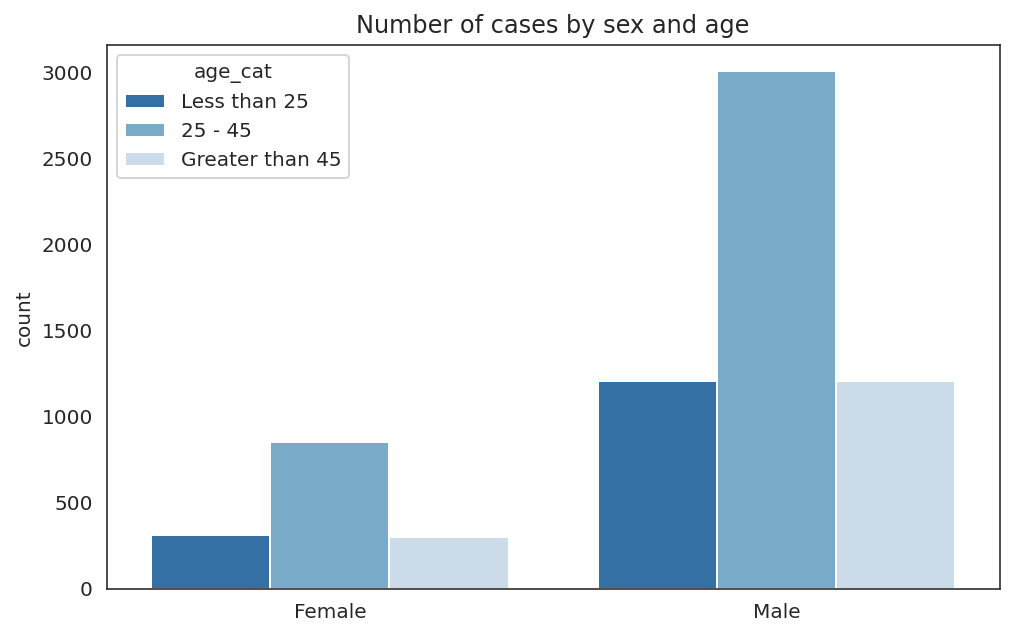

In [22]:
# we will see some data of the dataset according to sex; 
# as we saw before, male predominates, and in both cases age between 25-45 years old.

plt.figure(figsize=(8,5))
sns.countplot(data=df_final_c,x="sex",hue="age_cat",palette="Blues_r")
plt.title("Number of cases by sex and age")
plt.xlabel("")
# so only the graphic appears without any text referring to the object type.
plt.show(block=False)

In [23]:
# Here we also see the percentage of recidivism according to age and sex; 
# for example, men under 25 years of age have an average of 44% 
# and in general, men tend to recidivate more than women.
pd.pivot_table(data=df_final_c,index="sex",values="is_recid",columns="age_cat")

age_cat,Less than 25,25 - 45,Greater than 45
sex,,,
Female,0.266881,0.256741,0.172757
Male,0.444352,0.353059,0.237386


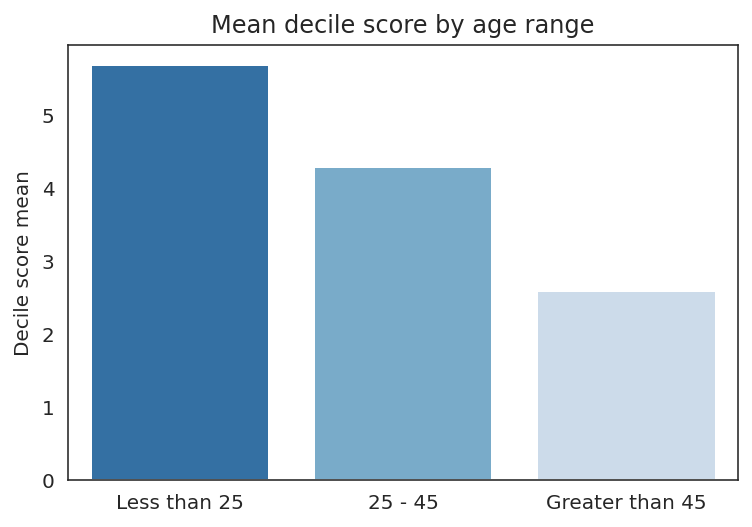

In [24]:
# as we saw before there is a correlation between age and decile score, the younger the more it penalizes.
decile_mean_age = df_final_c.groupby("age_cat")["decile_score"].mean().reset_index()
sns.barplot(data=decile_mean_age,x="age_cat",y="decile_score",palette="Blues_r")
plt.ylabel("Decile score mean")
plt.xlabel("")
plt.title("Mean decile score by age range")
# so only the graphic appears without any text referring to the object type.
plt.show(block=False)

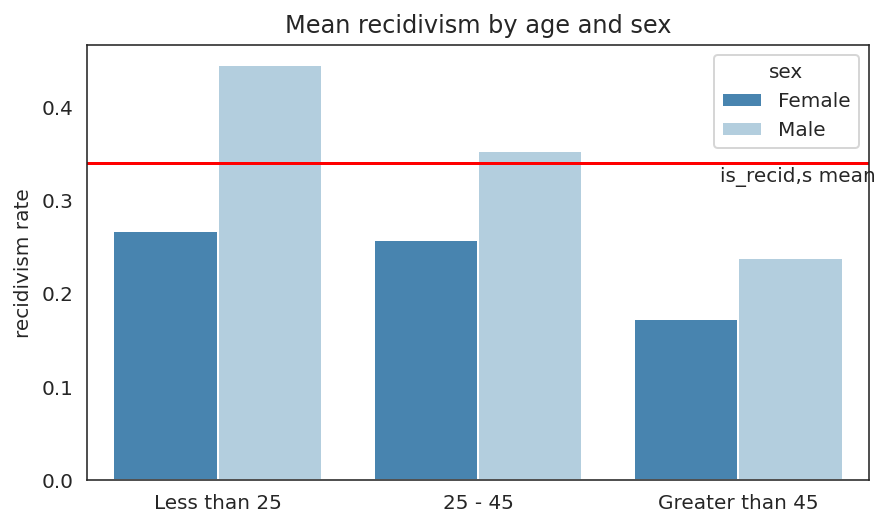

In [25]:
# We can plot the average recidivism rate by age and sex, 
# where we can see that it is decreasing as a function of age (more accentuated in men). 
sex_edad_recid = df_final_c.groupby(["sex","age_cat"])["two_years_r"].mean().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(data=sex_edad_recid,x="age_cat",y="two_years_r",hue="sex",palette="Blues_r")
plt.title("Mean recidivism by age and sex")
plt.xlabel("")
plt.ylabel("recidivism rate")
plt.axhline(y=0.34,color="red")
plt.text(x=1.93,y=0.32,s="is_recid,s mean")
# so only the graphic appears without any text referring to the object type.
plt.show(block=False)

### SEXO Y TIPOS DE DELITO

* I focus, because of their great variety, only on the 10 most typical.
* Many could be grouped by type of crime (drugs, vehicle, robbery and assault...) to facilitate the study of the data.

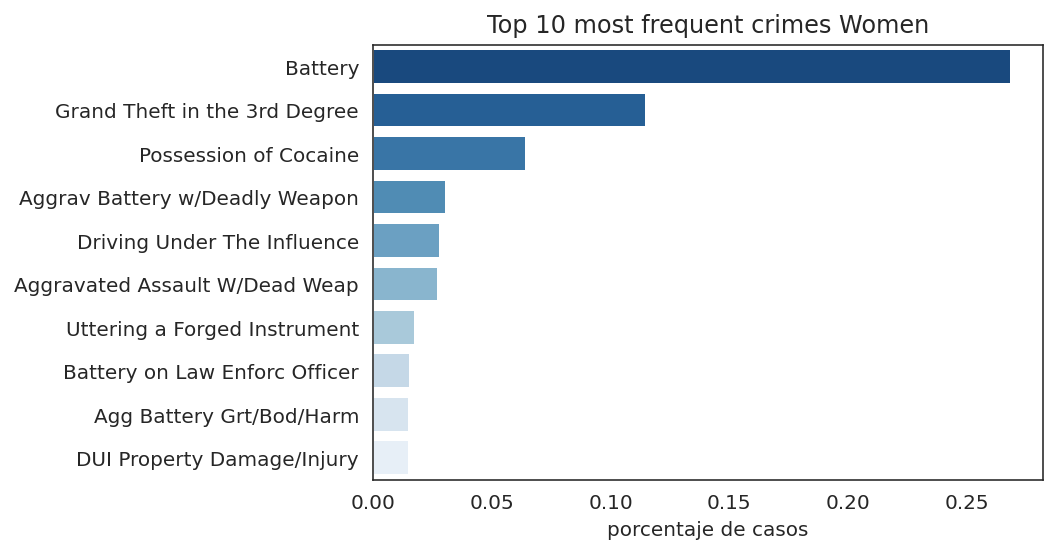

In [26]:
# by type of crime, we see the 10 most frequent cases for both men and women.
mujer= df_final_c[df_final_c["sex"]=="Female"]["c_charge_desc"].value_counts(normalize=True,ascending=False)[:10].reset_index()
sns.barplot(data=mujer,x="c_charge_desc",y="index",palette="Blues_r")
plt.title("Top 10 most frequent crimes Women")
plt.ylabel("")
plt.xlabel("porcentaje de casos")
# so only the graphic appears without any text referring to the object type.
plt.show(block=False)

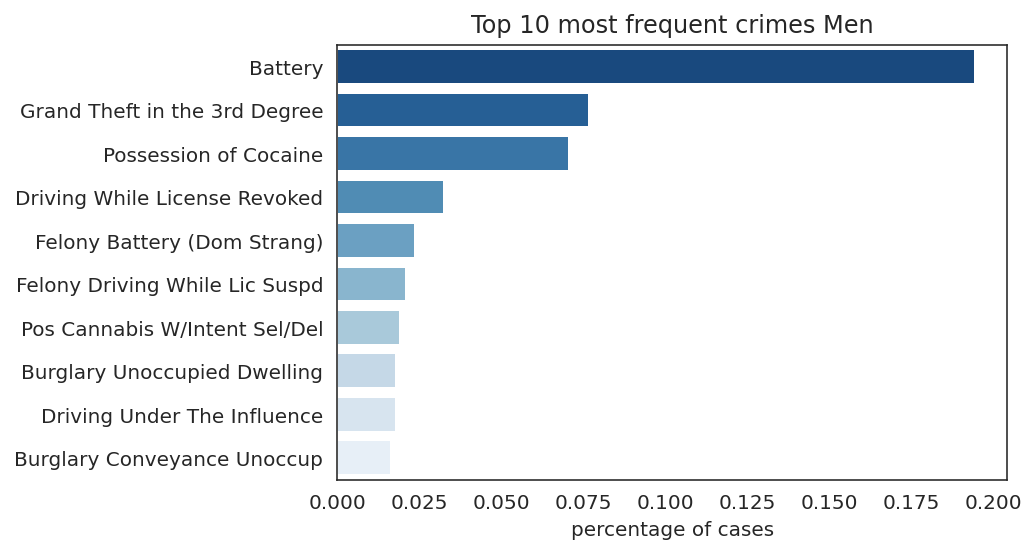

In [27]:
# the 4 most frequent offenses are common to both men and women, but then there are some differences
# (in women for example, there are two crimes, aggrav battery deadly weapon and aggravated assault dead weapon, which do not appear in men).
hombre= df_final_c[df_final_c["sex"]=="Male"]["c_charge_desc"].value_counts(normalize=True,ascending=False)[:10].reset_index()

sns.barplot(data=hombre,x="c_charge_desc",y="index",palette="Blues_r")
plt.title("Top 10 most frequent crimes Men")
plt.ylabel("")
plt.xlabel("percentage of cases")
# so only the graphic appears without any text referring to the object type.
plt.show(block=False)

### RACE

* With race, when looking at the statistics, we must always keep in mind that there is very little data on Asians and Native Americans (a good idea would be to group them together with Other in a single category to make it more representative).

* In general, we realize that almost 50% of the cases belong to African Americans and they are also the ones with the highest percentage of recidivism (almost 40% of the cases are African American).

* This is important because the dataset is not balanced and can be very biased due to the predominance of this ethnic group.



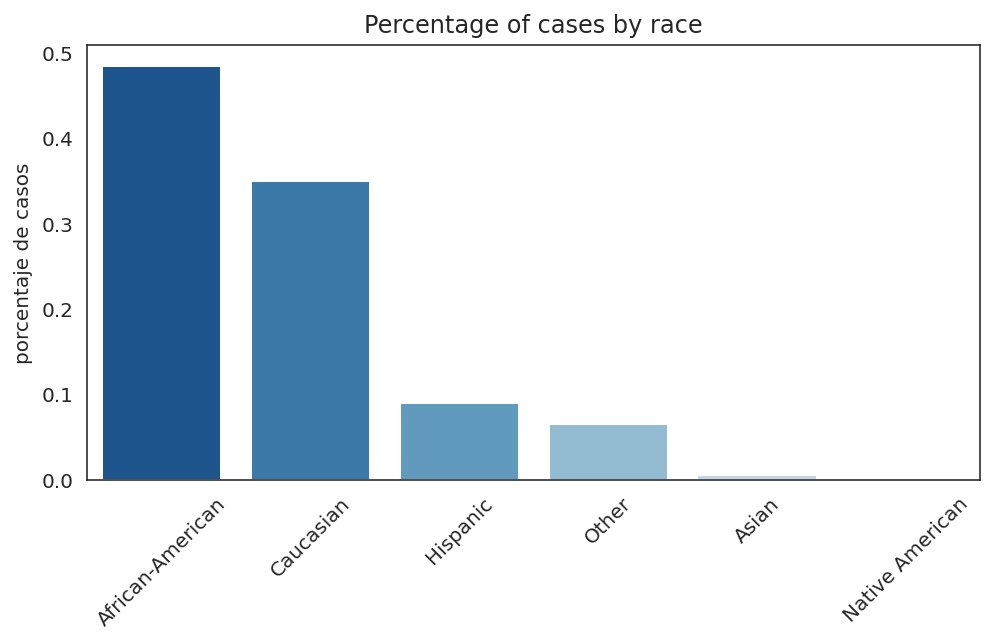

In [ ]:
raza = df_final_c["race"].value_counts(normalize=True,ascending=False).reset_index()

plt.figure(figsize=(8,4))days_b_sc
sns.barplot(x=raza["index"],y=raza["race"],palette="Blues_r")
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("porcentaje de casos")
plt.title("Percentage of cases by race")
# so only the graphic appears without any text referring to the object type.
plt.show(block=False)

In [29]:

# We see that almost 50% of the cases belong to African-Americans, 35% to Caucasians, and the rest are below 1%.
# As for recidivism rates, let's look at the data: 39% of African Americans are recidivists while among Caucasians, 27% of African Americans are recidivists. 
df_final_c.groupby("race",as_index=False)["two_years_r"].mean().style.background_gradient(cmap='Blues',axis=0)

,race,two_years_r
0,African-American,0.390836
1,Caucasian,0.275404
2,Hispanic,0.239550
3,Other,0.245077
4,Asian,0.128205
5,Native American,0.166667


In [30]:
# we now see the percentage of cases by race and age. In young people under 25 years of age, African-Americans predominate.
# and those over 45 are predominantly Caucasian and Asian. 

# using normalize = 0 we obtain percentages by rows. 
pd.crosstab(df_final_c["race"],df_final_c["age_cat"],normalize=0).style.background_gradient(cmap='Blues',axis=1)

age_cat,Less than 25,25 - 45,Greater than 45
race,,,
African-American,0.268643,0.579814,0.151542
Caucasian,0.164247,0.531730,0.304023
Hispanic,0.189711,0.581994,0.228296
Other,0.205689,0.551422,0.242888
Asian,0.179487,0.487179,0.333333
Native American,0.166667,0.555556,0.277778


In [31]:
# We can also look at recidivism percentages by race-age; 
# here again we confirm that those under 25 tend to recidivate more, especially African Americans under 25 (44%).
pd.crosstab(values=df_final_c["two_years_r"],index=df_final_c["race"],columns=df_final_c["age_cat"],aggfunc="mean")\
    .style.background_gradient(cmap='Blues',axis=1)

age_cat,Less than 25,25 - 45,Greater than 45
race,,,
African-American,0.444816,0.386880,0.310277
Caucasian,0.353535,0.299532,0.190996
Hispanic,0.330508,0.240331,0.161972
Other,0.382979,0.234127,0.153153
Asian,0.285714,0.052632,0.153846
Native American,0.666667,0.100000,0.000000


### MOST FREQUENT CHARGES, SEX AND RACE

We are going to analyze the most frequent offenses in the dataset, also by race and sex. I am only going to use the 10 most frequent cases since it is a bit difficult to work with them given the number of cases (more than 400). A good idea would be to group them by categories, as far as possible, e.g. drugs, weapons, trafficking etc... to facilitate the analysis.



In [32]:
# for the most frequent cases I will only use the 10 most usual ones; first I do a count with value_counts and then
# filter the dataset for these offenses with .isin
casos_mas_freq = df_final_c["c_charge_desc"].value_counts()[:10].index.tolist()
df_casos = df_final_c[df_final_c["c_charge_desc"].isin(casos_mas_freq)]


In [33]:
# let's look at the relationship between race and type of case (we saw it before in graph) a little bit more in depth; 
# we see that the usual is usually Battery, Grand Theft in the 3rd Degree, Possession of Cocaine;
# it is true that the proportion of battery(assault) is higher in Hispanics, Caucasians, Asians and Native Americans.
pd.crosstab(index=df_casos["c_charge_desc"],columns=df_casos["race"],normalize=1)\
    .style.background_gradient(cmap='Blues',axis=0)

race,African-American,Caucasian,Hispanic,Other,Asian,Native American
c_charge_desc,,,,,,
Battery,0.364937,0.461993,0.470383,0.533597,0.571429,0.666667
Burglary Unoccupied Dwelling,0.038760,0.021115,0.024390,0.031621,0.000000,0.000000
Driving Under The Influence,0.014908,0.077703,0.055749,0.011858,0.047619,0.111111
Driving While License Revoked,0.075134,0.032095,0.066202,0.031621,0.047619,0.000000
Felony Battery (Dom Strang),0.037567,0.033784,0.069686,0.047431,0.000000,0.111111
Felony Driving While Lic Suspd,0.052475,0.020270,0.045296,0.035573,0.000000,0.000000
Grand Theft (Motor Vehicle),0.035182,0.030405,0.010453,0.039526,0.047619,0.000000
Grand Theft in the 3rd Degree,0.194991,0.141892,0.153310,0.162055,0.190476,0.000000
Pos Cannabis W/Intent Sel/Del,0.037567,0.024493,0.020906,0.043478,0.000000,0.000000


In [34]:
# now let's look at the recidivism percentages between race and case type
pd.pivot_table(data=df_casos,values="two_years_r",index="c_charge_desc",columns="race",fill_value=0)\
    .style.background_gradient(cmap='Blues',axis=1)

race,African-American,Caucasian,Hispanic,Other,Asian,Native American
c_charge_desc,,,,,,
Battery,0.334967,0.224863,0.192593,0.162963,0.000000,0.166667
Burglary Unoccupied Dwelling,0.446154,0.160000,0.285714,0.125000,0.000000,0.000000
Driving Under The Influence,0.240000,0.184783,0.062500,0.000000,0.000000,0.000000
Driving While License Revoked,0.484127,0.368421,0.368421,0.375000,0.000000,0.000000
Felony Battery (Dom Strang),0.222222,0.250000,0.300000,0.083333,0.000000,0.000000
Felony Driving While Lic Suspd,0.375000,0.208333,0.307692,0.444444,0.000000,0.000000
Grand Theft (Motor Vehicle),0.423729,0.250000,0.333333,0.400000,0.000000,0.000000
Grand Theft in the 3rd Degree,0.318043,0.375000,0.227273,0.146341,0.250000,0.000000
Pos Cannabis W/Intent Sel/Del,0.492063,0.137931,0.500000,0.181818,0.000000,0.000000


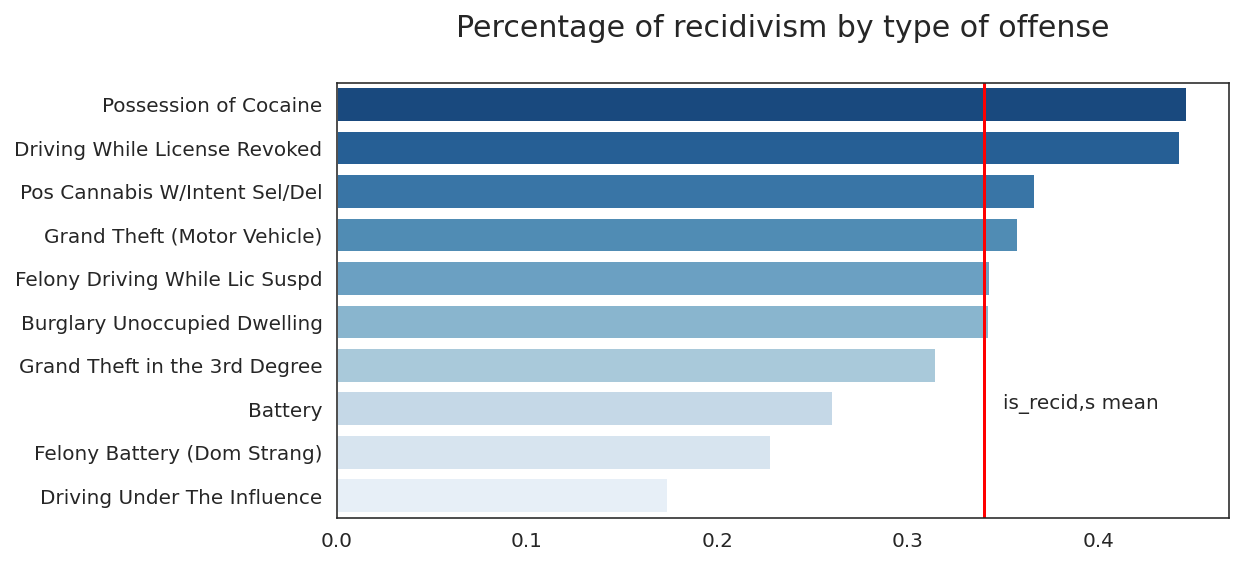

In [35]:
# we can also see only percentage of recidivism, regardless of race and sex (driving with expired license, drugs and car theft)
casos_recid_per= df_casos.groupby("c_charge_desc")["two_years_r"].mean().reset_index().sort_values(by="two_years_r",ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(data=casos_recid_per,y="c_charge_desc",x="two_years_r",palette="Blues_r")
plt.title("Percentage of recidivism by type of offense\n",fontsize=15)
plt.xlabel("")
plt.ylabel("")
plt.axvline(x=0.34,color="red")
plt.text(x=0.35,y=7,s="is_recid,s mean")
# so only the graphic appears without any text referring to the object type.
plt.show(block=False)

### CONTINGENCY TABLES

* Now we will see how well the model performs; by means of a contingency table we will take out the type I and II errors.
* We will also compare the two models (ordinary and violent crime) to see which one does better.
* We will also see how it performs by both race and sex.

In [36]:
# as before I already created a binary decile score column, by doing a crosstab I have the contingency table
# with normalize = columns we can have TPR, FPR, FNR, TNR
cros = pd.crosstab(df_final_c["binary_decile_score"],df_final_c['two_years_r'],normalize="columns")
cros

two_years_r,0,1
binary_decile_score,,
0,0.672332,0.405273
1,0.327668,0.594727


In [37]:
# tambien podemos usar sklearn
from sklearn.metrics import classification_report
print(classification_report(df_final_c['two_years_r'],df_final_c["binary_decile_score"]))

              precision    recall  f1-score   support

           0       0.78      0.67      0.72      4648
           1       0.47      0.59      0.52      2238

    accuracy                           0.65      6886
   macro avg       0.62      0.63      0.62      6886
weighted avg       0.67      0.65      0.66      6886



* has an accuracy of 65%.
* of the actual negative cases it predicts 68% and of those it has predicted that are negative it is right in 77% of the cases 
77% of the cases
* of the actual positive cases it predicts 59% and of those it predicts as positive it is correct in 47% of the cases.
* so we can see the false-positive rate (1-true negative rate): 1-0.68 = 0.32
* and the false negative rate (1-true positive rate):1-0.59 = 0.41

In [38]:
# let's see how it predicts violent crime
pd.crosstab(df_final_v["binary_v_decile_score"],df_final_v['two_years_v'],normalize="columns")

two_years_v,0,1
binary_v_decile_score,,
0,0.705258,0.478903
1,0.294742,0.521097


In [39]:
print(classification_report(df_final_v['two_years_v'],df_final_v["binary_v_decile_score"]))

              precision    recall  f1-score   support

           0       0.95      0.71      0.81      6504
           1       0.11      0.52      0.19       474

    accuracy                           0.69      6978
   macro avg       0.53      0.61      0.50      6978
weighted avg       0.90      0.69      0.77      6978



Before comparing the data, it should be noted:

* that this last dataset is more unbalanced than the one for ordinary crimes, as we can see below, so it will tend to predict worse the positive cases compared to the previous one.

In [40]:
df_final_v['two_years_v'].value_counts(normalize=True)

0    0.932072
1    0.067928
Name: two_years_v, dtype: float64

In [41]:
df_final_c["two_years_r"].value_counts(normalize=True)

0    0.674993
1    0.325007
Name: two_years_r, dtype: float64

* It is true that the accuracy is a little higher, but as we saw before, the dataset is not balanced.
* In cases of violent crime, it is less accurate for positive cases (fi=19%).
* Of the latter, it predicts 52% of the actual cases, but of those it predicts, only 12% are correct.
* FPR=29%, FNR=47%.
* In summary, it has more acuracy but is less accurate than general crime for positive cases.

### COMPAS VS RACE and SEX

We first compare the actual recidivism rate vs. that predicted by Compas; for Caucasians and Hispanics they are very even but for African-Americans the prediction is much higher than actual cases

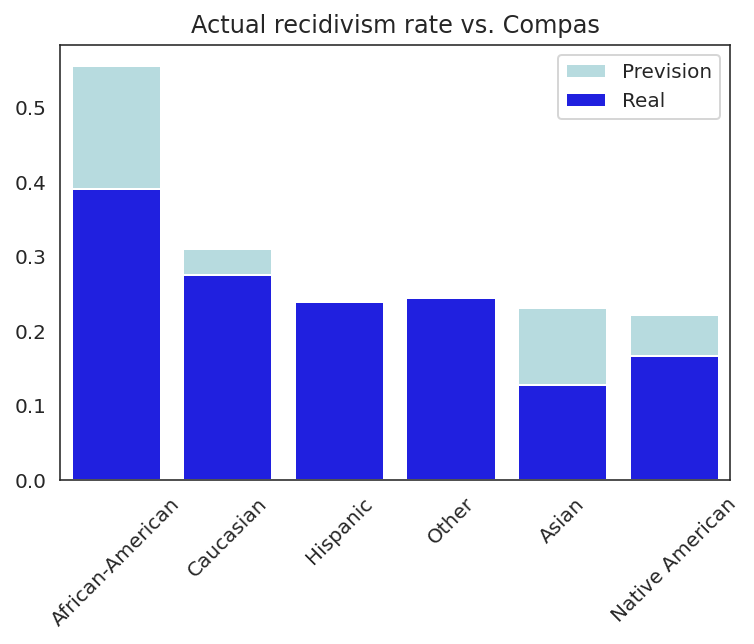

In [42]:
# comparamos reincidencia real vs prevision compas
real = df_final_c.groupby("race",as_index=False)["two_years_r"].mean()
compas = df_final_c.groupby("race")["binary_decile_score"].mean().reset_index()

sns.barplot(data=compas,x="race",y="binary_decile_score",color="powderblue",label="Prevision")

ax= sns.barplot(data=real,x="race",y="two_years_r",color="blue",label="Real")

plt.title("Actual recidivism rate vs. Compas")
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("")
plt.legend()
# so only the graphic appears without any text referring to the object type.
plt.show(block=False)

In [43]:
df_final_c.groupby("race").agg({"two_years_r":"mean",
                                    "binary_decile_score":"mean"})

,two_years_r,binary_decile_score
race,,
African-American,0.390836,0.555556
Caucasian,0.275404,0.310245
Hispanic,0.239550,0.239550
Other,0.245077,0.194748
Asian,0.128205,0.230769
Native American,0.166667,0.222222


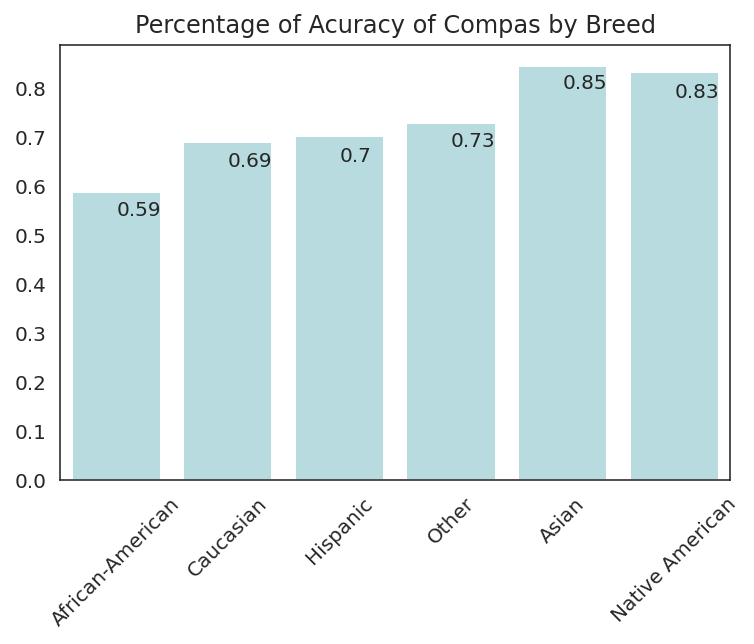

In [44]:
accuracy_race = df_final_c.groupby("race")["recid_comparison_column"].mean().reset_index()
ax= sns.barplot(data=accuracy_race,x="race",y="recid_comparison_column",color="powderblue")
plt.title("Percentage of Acuracy of Compas by Breed")
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("")
for num,text in zip(range(6),round(accuracy_race["recid_comparison_column"],2)):
    ax.text(num,text-0.05,text)

By sex we can see that males are more recidivists than females, both for Compas and in reality. In terms of accuracy there is no difference between the two (65%).


In [45]:
# por sexo
sex_prevision = df_final_c.groupby("sex")["binary_decile_score"].mean()
sex_recid = df_final_c.groupby("sex")["two_years_r"].mean()
comparacion_sex = df_final_c.groupby("sex")["recid_comparison_column"].mean()

df_comparacion_sex_recid = pd.concat([sex_prevision,sex_recid,comparacion_sex],axis=1).reset_index()
df_comparacion_sex_recid.columns = ["sex","decile_score","two_years_r","accuracy"]
df_comparacion_sex_recid.round(2)

,sex,decile_score,two_years_r,accuracy
0,Female,0.38,0.24,0.65
1,Male,0.42,0.35,0.65


## PERCENTAGE OF FALSE POSITIVES AND FALSE NEGATIVES

* Using a couple of functions we get both data and realize that:
* by race, African Americans have a much higher percentage of false positives than the rest (indicating that they are more likely to be incorrectly determined to be recidivists ,and denied bail)), and in turn have a lower percentage of false negatives than the rest.
* By sex, the percentage of false positives is slightly higher in men than in women, but the percentage of false negatives is slightly higher in women than in men.
* The recidivism rate, per decile point score, is very similar for both African-Americans and Caucasians.

In [46]:
def falsos_rate(col):
    #creamos dos listas, una para nombre de la columna y otra para el resultado
    lista_col = []
    FPR = []
    FNR = []
    for x in df_final_c[col].unique().tolist():    
        #filtramos por raza o sexo
        datos = df_final_c[df_final_c[col]==x] 
        #creamos clasificacion report (con output_dict nos devuelve un dicionario)   
        classif_race = classification_report(datos['two_years_r'],datos["binary_decile_score"],output_dict=True)
        lista_col.append(x)
        # la tasa de falso positivo es 1-exahustividad(recall)
        falso_pos = 1 - classif_race.get("0")["recall"]
        FPR.append(falso_pos)
        # falso negativos 1-TPR
        falso_neg = 1 - classif_race.get("1")["recall"]
        FNR.append(falso_neg)
    # creamos dataframe
    df_fpr = pd.DataFrame({x:lista_col,"FPR":FPR,"FNR":FNR})
    return df_fpr

In [47]:
falsos_rate("race")

,Native American,FPR,FNR
0,Other,0.144928,0.651786
1,African-American,0.471976,0.314176
2,Caucasian,0.236978,0.496988
3,Hispanic,0.194503,0.617450
4,Asian,0.147059,0.200000
5,Native American,0.133333,0.333333


In [48]:
falsos_rate("sex")

,Female,FPR,FNR
0,Male,0.330789,0.400212
1,Female,0.317732,0.432203


We can also see that, for each decile score, the percentage of recidivism is similar in both breeds.

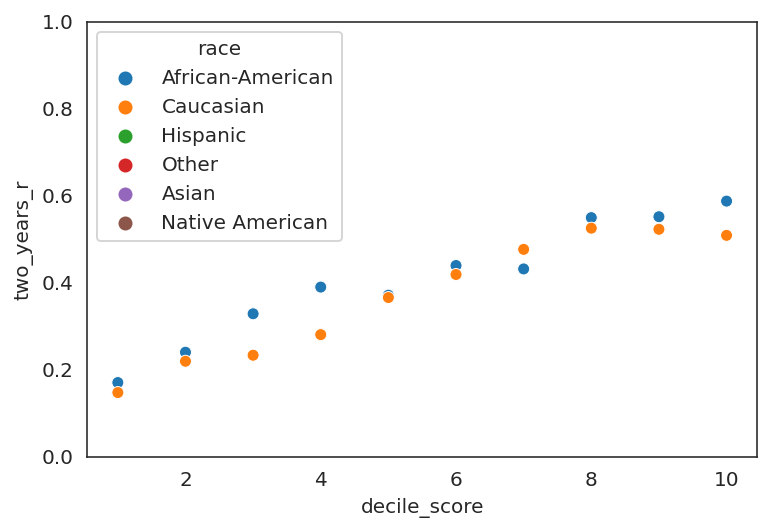

In [49]:
d = df_final_c.groupby(["decile_score","race"]).agg({"two_years_r":"mean"}).reset_index()
d = d[d["race"].isin(["African-American","Caucasian"])]
im = sns.scatterplot(data=d,x="decile_score",y="two_years_r",hue="race")
im.set(ylim=(0,1))
# so only the graphic appears without any text referring to the object type.
plt.show(block=False)

#### SUMMARY

* The input dataset is unbalanced since one of the races predominates over the others, this can lead to biases in the preditions.
preditions.
* We have cleaned and filtered the dataset to get homogeneous data.
* We have created a feature, which we will use to predict (two_year_r), which assures us that is has been a repeat offender within two years after the Compas report.
* We have seen how is_recid and is_violent_racid predict; the latter with a slightly higher accuracy but does not do so as well.
with the positive cases
* we have seen by race and sex how compas evaluates; there are some differences in results with races but we must not lose sight of
what we said before about the prevalence in the data of one of the races (almost 50%) and they are also the most recidivists (almost 40%)
* We also saw that there are important factors for the model like: age, background, years in prison, type of crime...

